In [14]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization

from tensorflow.keras.regularizers import l1, l2

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import optuna

In [2]:
num_classes = 19 #0 - 18
np.random.seed(441)
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

def dataset(X, Y):
    imgs = []
    labels = []

    for _ in range(len(X)):
        i, j = np.random.choice(len(X), size=2, replace=False)
        img1, img2 = X[i], X[j]
        combined_img = np.hstack((img1, img2))
        combined_label = Y[i] + Y[j]
        imgs.append(combined_img)
        labels.append(combined_label)
    return np.array(imgs), np.array(labels)

x_train, y_train = dataset(x_train, y_train)
x_test, y_test = dataset(x_test, y_test)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 56)
y_train shape: (60000,)
60000 train samples
10000 test samples


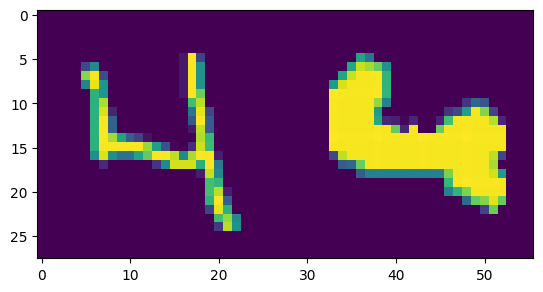

8


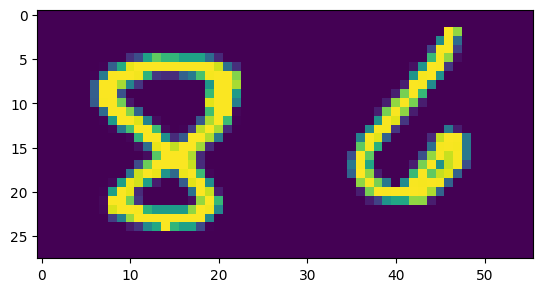

14


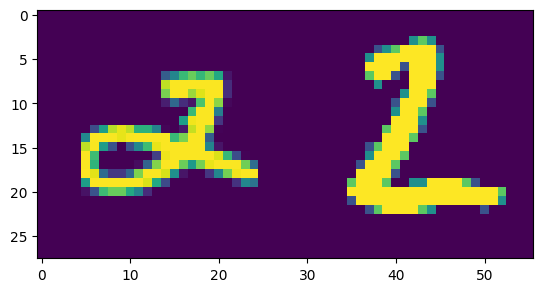

4


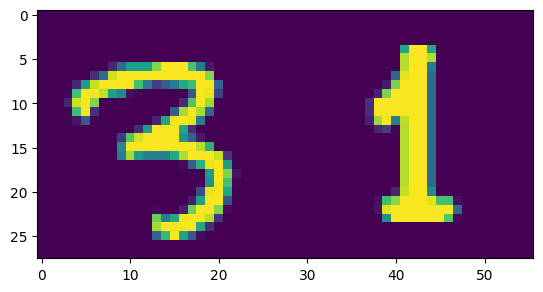

4


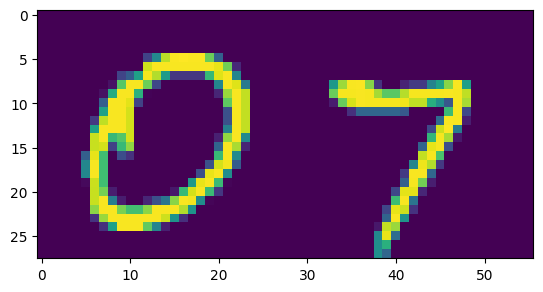

7


In [3]:
for i in range(5):
    plt.imshow(x_train[i])
    plt.show()
    print(np.where(y_train[i]==1)[0][0])

In [6]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    n_neurons = trial.suggest_int('n_neurons', 100, 600)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.01)
    l1_regularization = trial.suggest_float('l1_regularization', 1e-5, 1e-3)
    n_layers = trial.suggest_int('n_layers', 1, 6)
    
    model = Sequential()
    model.add(Flatten(input_shape=(56, 28)))

    for _ in range(n_layers):
        model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l1(l1_regularization)))
        model.add(Dropout(dropout_rate))

    model.add( Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20,
                        batch_size=128, verbose=0)

    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-23 02:48:41,710] A new study created in memory with name: no-name-814f42f3-2f42-4104-811b-511048bd85e5
[I 2024-11-23 02:49:58,489] Trial 0 finished with value: 0.7332000136375427 and parameters: {'learning_rate': 7.207851428574715e-05, 'n_neurons': 153, 'dropout_rate': 0.0026079535814324305, 'l1_regularization': 0.000400510600037763, 'n_layers': 3}. Best is trial 0 with value: 0.7332000136375427.
[I 2024-11-23 02:53:30,406] Trial 1 finished with value: 0.7534999847412109 and parameters: {'learning_rate': 2.5669390491403946e-05, 'n_neurons': 414, 'dropout_rate': 0.00427440645272586, 'l1_regularization': 0.0002183306177289396, 'n_layers': 6}. Best is trial 1 with value: 0.7534999847412109.
[I 2024-11-23 02:54:59,475] Trial 2 finished with value: 0.319599986076355 and parameters: {'learning_rate': 0.0001619143748462223, 'n_neurons': 135, 'dropout_rate': 0.008714639383496613, 'l1_regularization': 0.0008188732728378618, 'n_layers': 5}. Best is trial 1 with value: 0.75349998474121

In [7]:
print('Best trial:')
print(f' Value: {study.best_trial.value}')
print(' Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')


Best trial:
 Value: 0.9337000250816345
 Params: 
    learning_rate: 0.0008346505110537525
    n_neurons: 402
    dropout_rate: 0.0076255205790826015
    l1_regularization: 4.595480885235088e-05
    n_layers: 6


In [13]:
def create_and_save_model(params):
    
    model = Sequential()
    model.add(Flatten(input_shape=(56, 28)))
    print()
    for _ in range(params.get('n_layers')):
        model.add(Dense(params.get('n_neurons'), activation='relu', kernel_regularizer=l1(params.get('l1_regularization'))))
        model.add(Dropout(params.get('dropout_rate')))

    model.add( Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(params.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50,
                        batch_size=128, verbose=1)

    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]
    print(accuracy)
    model.save('nn_model.keras')

create_and_save_model(study.best_trial.params)

/home/ljf1/dis/disvenv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.2980 - loss: 3.4411 - val_accuracy: 0.7848 - val_loss: 1.5648
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8310 - loss: 1.4090 - val_accuracy: 0.8684 - val_loss: 1.1983
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8954 - loss: 1.0835 - val_accuracy: 0.8879 - val_loss: 1.0431
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9213 - loss: 0.9119 - val_accuracy: 0.9013 - val_loss: 0.9369
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9374 - loss: 0.7935 - val_accuracy: 0.9121 - val_loss: 0.8480
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9454 - loss: 0.7077 - val_accuracy: 0.9166 - val_loss: 0.7889
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9513 - loss: 0.6464 - val_accuracy: 0.9230 - val_loss: 0.7297
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9579 - loss: 0.5884 - va

In [15]:
model = load_model('nn_model.keras')

In [16]:
model.predict()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_54 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 402)            │       630,738 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_219 (Dropout)           │ (None, 402)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 402)            │       162,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ (None, 402)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 402)            │       162,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 402)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 402)            │       162,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 402)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 402)            │       162,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 402)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 402)            │       162,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_224 (Dropout)           │ (None, 402)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 19)             │         7,657 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,345,277 (16.58 MB)

 Trainable params: 1,448,425 (5.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,896,852 (11.05 MB)